In [300]:
import pandas as pd


import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

#contemplado para cuando se necesite 
#from currency_converter import CurrencyConverter

In [172]:
#inicializar currencyConverter
#c = CurrencyConverter()

In [173]:
df = pd.read_csv('../../data/capology/all_players_2016_2021.csv')

In [174]:
df.shape

(20006, 16)

In [175]:
df.dtypes

Unnamed: 0.2            int64
Unnamed: 0.1            int64
Unnamed: 0            float64
Player                 object
Gross P/W(IN EUR)      object
Gross P/Y(IN EUR)      object
Adj. Gross(IN EUR)     object
Pos. DFKM              object
Age                     int64
Country                object
Team                   object
League                 object
Season                 object
Gross P/W(IN GBP)      object
Gross P/Y(IN GBP)      object
Adj. Gross(IN GBP)     object
dtype: object

# Clean data

De acuerdo con https://www.exchangerates.org.uk/EUR-GBP-spot-exchange-rates-history-2022.html#:~:text=This%20is%20the%20Euro%20(EUR,rate%20in%202022%3A%200.8527%20GBP. 

En 2022 el valor promedio de un euro fue de 0.8526 GBP (o 1.17 GBP = 1 EUR). 

In [176]:
df = df.drop(columns = ['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'])


- checar como están ajustados a la inflación
- convertir todo a euros
- juntar columnas


---

In [177]:
def currency_to_num(df):
    
    for col in df.columns:
        if df[col].dtype != 'int64':
            df[col] = df[col].str.replace('€ ', '')
            df[col] = df[col].str.replace('£ ', '')
            df[col] = df[col].str.replace(',', '')

    
    df = df.apply(pd.to_numeric, errors = 'ignore')
    
    return df

In [178]:
df_temp.dtypes

Player                 object
eur                   float64
Gross P/Y(IN EUR)     float64
Adj. Gross(IN EUR)    float64
Pos. DFKM              object
Age                     int64
Country                object
Team                   object
League                 object
Season                 object
Gross P/W(IN GBP)     float64
Gross P/Y(IN GBP)     float64
Adj. Gross(IN GBP)    float64
year                    int64
dtype: object

In [191]:
df_temp = df.copy()

#pasar columnas a velor numérico
df_temp = currency_to_num(df_temp)

df_temp['year'] = df_temp['Season'].astype(str).str.extract('([0-9]{4})')
df_temp['year'] = pd.to_numeric(df_temp['year'])

#df_temp.sort_values(by='Adj. Gross(IN EUR)', ascending=False).head(5)

In [180]:
#ajustar monedas, pasar todo a euros (2022, solo nos sirve adjusted)
df_temp['Gross P/W(IN GBP)'] = df_temp['Gross P/W(IN GBP)']*1.1728829
df_temp['Gross P/Y(IN GBP)'] = df_temp['Gross P/Y(IN GBP)']*1.1728829
df_temp['Adj. Gross(IN GBP)'] = df_temp['Adj. Gross(IN GBP)']*1.1728829


In [181]:
rest = df_temp[df_temp['League'] != 'Premier League']

In [182]:
#have all data in one col
pl = df_temp[df_temp['League'] == 'Premier League'].copy()

pl['Gross P/W(IN EUR)'] = pl['Gross P/W(IN GBP)']
pl['Gross P/Y(IN EUR)'] = pl['Gross P/Y(IN GBP)']
pl['Adj. Gross(IN EUR)'] = pl['Adj. Gross(IN GBP)']

In [207]:
df_final = pd.concat([rest,pl])
df_final = df_final.drop(columns = ['Gross P/W(IN GBP)','Gross P/Y(IN GBP)','Adj. Gross(IN GBP)'])
                         
df_final = df_final.rename(columns = {'Gross P/W(IN EUR)':'weekly_eur', 'Gross P/Y(IN EUR)': 'yearly_eur', 'Adj. Gross(IN EUR)': 'adj_eur',
                          'Pos. DFKM': 'pos'
                         })

df_final.columns= df_final.columns.str.lower()

df_final = df_final.rename(columns = {df_final.columns[4]: 'pos'}) 

In [208]:
df_final

,player,weekly_eur,yearly_eur,adj_eur,pos,age,country,team,league,season,year
0,Jonathan Schmid,22096.000,1149000.000,1229268.000,D,26,France,Augsburg,Bundesliga,2016-2017,2016
1,Martin Hinteregger,22096.000,1149000.000,1229268.000,D,23,Austria,Augsburg,Bundesliga,2016-2017,2016
2,Ja-cheol Koo,22096.000,1149000.000,1229268.000,M,27,South Korea,Augsburg,Bundesliga,2016-2017,2016
3,Dong-won Ji,19154.000,996000.000,1065579.000,F,25,South Korea,Augsburg,Bundesliga,2016-2017,2016
4,Raúl Bobadilla,19154.000,996000.000,1065579.000,F,29,Paraguay,Augsburg,Bundesliga,2016-2017,2016
...,...,...,...,...,...,...,...,...,...,...,...
15212,Rayan Aït-Nouri,11728.829,609899.108,609899.108,D,20,France,Wolverhampton,Premier League,2021-2022,2021
15213,Chiquinho,11728.829,609899.108,609899.108,F,21,Portugal,Wolverhampton,Premier League,2021-2022,2021
15214,Yerson Mosquera,9383.063,487919.286,487919.286,D,20,Colombia,Wolverhampton,Premier League,2021-2022,2021
15215,John Ruddy,6766.361,351864.870,351864.870,K,35,England,Wolverhampton,Premier League,2021-2022,2021


# EDA

In [233]:
def count_filters(df, col, threshold):
    '''
    antes de hacer un groupby, esto filtra para que solo se hagan las agregaciones
    para grupos que tienen cierto número de registros
    '''
    
    count_df = df.groupby(by=col).count().reset_index()
    count_df = count_df[count_df.iloc[:, 1] > threshold]
    
    items = list(count_df[col].unique())
    
    df_res = df.loc[df[col].isin(items)]
    
    return df_res
    

<AxesSubplot:xlabel='Count', ylabel='season'>

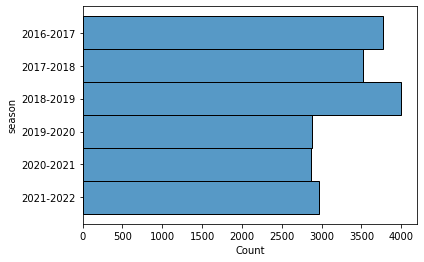

In [254]:
sns.histplot(df_final, y = 'season')

In [246]:
#mexicanos y num de temporadas
(df_final[df_final['country'] == 'Mexico']
 .groupby(by='player')
 .count()
 .reset_index()
 .sort_values(by='adj_eur', ascending=False)
)

,player,weekly_eur,yearly_eur,adj_eur,pos,age,country,team,league,season,year
0,Andrés Guardado,5,5,5,5,5,5,5,5,5,5
3,Chicharito,4,4,4,4,4,4,4,4,4,4
4,Diego Lainez,4,4,4,4,4,4,4,4,4,4
20,Raúl Jiménez,4,4,4,4,4,4,4,4,4,4
8,Hirving Lozano,3,3,3,3,3,3,3,3,3,3
9,Héctor Herrera,3,3,3,3,3,3,3,3,3,3
10,Héctor Moreno,3,3,3,3,3,3,3,3,3,3
1,Carlos Salcedo,3,3,3,3,3,3,3,3,3,3
15,Marco Fabián,3,3,3,3,3,3,3,3,3,3
2,Carlos Vela,2,2,2,2,2,2,2,2,2,2


In [250]:
df_test = count_filters(df_final, 'country', 100)

(df_test
 .groupby(by='country')
 .mean()
 .sort_values(by='adj_eur', ascending=False)
)

,weekly_eur,yearly_eur,adj_eur,age,year
country,,,,,
Belgium,63338.725,3293614.147,3376496.533,24.714,2018.305
Wales,61233.947,3184165.472,3272047.998,24.982,2018.123
Argentina,60335.730,3137458.026,3211592.698,27.016,2018.195
Brazil,57154.281,2972022.620,3033687.287,25.717,2018.357
Portugal,57062.780,2967264.459,3023695.694,24.848,2018.560
Croatia,48298.347,2511514.187,2564614.484,24.646,2018.246
Bosnia-Herzegovina,45258.127,2353422.084,2400371.305,27.126,2018.272
Uruguay,44992.383,2339605.697,2389124.418,25.179,2018.394
Netherlands,43784.772,2276806.490,2331221.073,25.060,2018.727


In [201]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [202]:
df_final.describe()

,weekly_eur,yearly_eur,adj_eur,age,year
count,20006.000,20006.000,20006.000,20006.000,20006.000
mean,33117.774,1722124.005,1762731.203,24.812,2018.322
std,62314.653,3240362.098,3304496.620,4.699,1.697
min,0.000,0.000,0.000,14.000,2016.000
25%,3269.000,170000.000,175669.750,21.000,2017.000
50%,14231.000,740000.000,750265.000,24.000,2018.000
75%,38118.694,1982172.101,2050000.000,28.000,2020.000
max,1384615.000,72000000.000,73196126.000,43.000,2021.000


In [200]:
df_final.sort_values(by='age')

,player,weekly_eur,yearly_eur,adj_eur,pos. dfkm,age,country,team,league,season,year
16732,Emanuel Ercolano,0.0,0.0,0.0,D,14,Italy,Sampdoria,Serie A,2017-2018,2017
16691,Devid Eugene Bouah,0.0,0.0,0.0,D,15,Italy,Roma,Serie A,2017-2018,2017
16907,Manuel Gasparini,0.0,0.0,0.0,K,15,Italy,Udinese,Serie A,2017-2018,2017
9288,Eduardo Camavinga,0.0,0.0,0.0,M,15,France,Rennes,Ligue 1,2018-2019,2018
16900,Semuel Pizzignacco,0.0,0.0,0.0,K,15,Italy,Udinese,Serie A,2017-2018,2017
...,...,...,...,...,...,...,...,...,...,...,...
18379,Gianluigi Buffon,53462.0,2780000.0,2832091.0,K,41,Italy,Juventus,Serie A,2019-2020,2019
9708,Hilton,13846.0,720000.0,731825.0,D,41,Brazil,Montpellier,Ligue 1,2019-2020,2019
19045,Gianluigi Buffon,53462.0,2780000.0,2780000.0,K,42,Italy,Juventus,Serie A,2020-2021,2020
9709,Hilton,13846.0,720000.0,731825.0,D,42,Brazil,Montpellier,Ligue 1,2019-2020,2019


<AxesSubplot:xlabel='league', ylabel='adj_eur'>

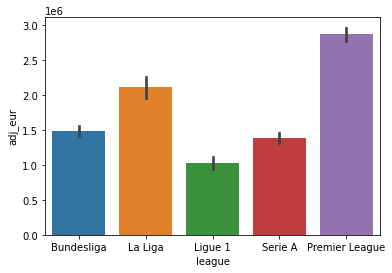

In [222]:
sns.barplot(data=df_final, x="league", y="adj_eur")


<AxesSubplot:xlabel='year', ylabel='adj_eur'>

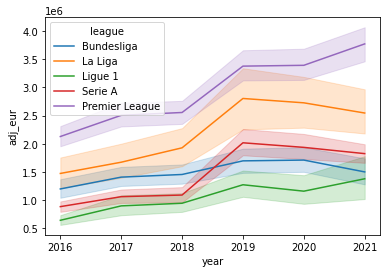

In [194]:
sns.lineplot(data=df_final, x="year", y="adj_eur", hue="league")


<AxesSubplot:xlabel='pos', ylabel='adj_eur'>

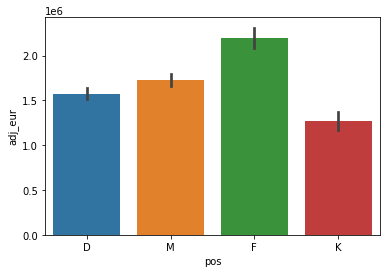

In [209]:
sns.barplot(data=df_final, x="pos", y="adj_eur")


<AxesSubplot:xlabel='year', ylabel='adj_eur'>

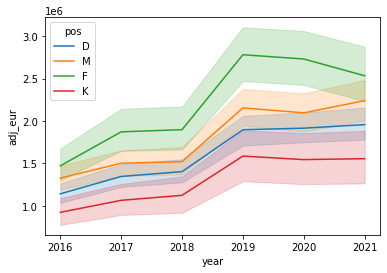

In [251]:
sns.lineplot(data=df_final, x="year", y="adj_eur", hue="pos")


<AxesSubplot:xlabel='age', ylabel='adj_eur'>

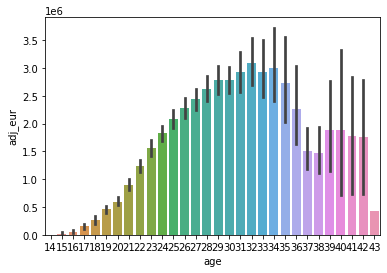

In [223]:
sns.barplot(data=df_final, x="age", y="adj_eur")


In [217]:
(df_final.groupby(by='country')
         .mean()
         .sort_values(by='adj_eur', ascending=False)
         .head(10)
        )

,weekly_eur,yearly_eur,adj_eur,age,year
country,,,,,
Burundi,93830.632,4879192.864,5217923.400,22.333,2016.333
Armenia,92976.512,4834779.263,5040853.788,27.462,2018.923
Egypt,72831.804,3787255.493,3873012.391,25.760,2018.560
Kenya,63543.711,3304275.362,3460578.139,25.800,2017.400
Costa Rica,64513.964,3354728.981,3412797.112,29.292,2017.750
Chile,62915.324,3271600.251,3387650.830,28.662,2018.108
Belgium,63338.725,3293614.147,3376496.533,24.714,2018.305
Gabon,62194.516,3234111.880,3307099.979,25.676,2018.176
Wales,61233.947,3184165.472,3272047.998,24.982,2018.123


In [221]:
df_final.groupby(by = 'country').count()

,player,weekly_eur,yearly_eur,adj_eur,pos,age,team,league,season,year
country,,,,,,,,,,
Afghanistan,1,1,1,1,1,1,1,1,1,1
Albania,77,77,77,77,77,77,77,77,77,77
Algeria,159,159,159,159,159,159,159,159,159,159
Angola,21,21,21,21,21,21,21,21,21,21
Argentina,563,563,563,563,563,563,563,563,563,563
...,...,...,...,...,...,...,...,...,...,...
Uzbekistan,2,2,2,2,2,2,2,2,2,2
Venezuela,56,56,56,56,56,56,56,56,56,56
Wales,114,114,114,114,114,114,114,114,114,114


In [324]:
top_teams = (df_final
             .groupby(by = ['team'])
             .mean()
             .reset_index()
             .sort_values(by='adj_eur', ascending=False)
             .head(10)
            )


<AxesSubplot:xlabel='adj_eur', ylabel='team'>

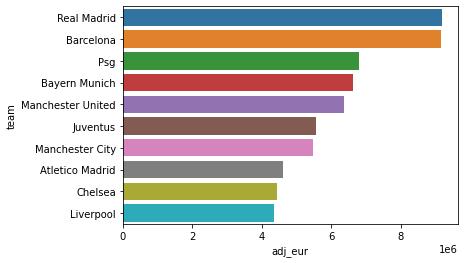

In [325]:
sns.barplot(data = top_teams, y='team', x='adj_eur')